## import necessary libraries

In [2]:
#pip install POT

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import arff
import ot

In [4]:
def qq_and_potential_plots(x,y,p_x,p_y,la=1e-2):
  """ Draws multivariate qq and potential plots. Two rows of bivariate plots, the first row is OT qq plot and the second one is EOT qq plot.

  Parameter
  ---------
  x : a matrix of order (d,n_1)
      first sample of size n_1 in dimension d

  y : a matrix of order (d,n_2)
      second sample of size n_2 in dimension d

  p_x : 1d array of size n_1 with positive entries
        likelihood of each of the sample points of x

  p_y : 1d array of size n_2 with positive entries
        likelihood of each of the sample points of y

  la : float, positive
        regularisation parameter in Entropic optimal transport


  """

  def quantile_plots(xot,yot,xeot,yeot):
    'Compare the quantiles componentwise'
    fig,ax=plt.subplots(2,xot.shape[0],figsize=(d*4,(d-1)*4))
    outlier_ot=np.argsort(yot[0,:])[::-1][:3]
    outlier_eot=np.argsort(yeot[0,:])[::-1][:3]
    for j in range(xot.shape[0]):
        ax[0,j].scatter(xot[j,:],yot[j,:],color='r',s=1)
        xmin,xmax=min(np.min(xot[j,:]),np.min(yot[j,:])),max(np.max(xot[j,:]),np.max(yot[j,:]))
        l1=np.linspace(xmin,xmax,100)
        ax[0,j].plot(l1,1*l1,'k',linewidth=1)
        ### Sinkhorn EOT
        ax[1,j].scatter(xeot[j,:],yeot[j,:],color='r',s=1)
        xmin,xmax=min(np.min(xeot[j,:]),np.min(yeot[j,:])),max(np.max(xeot[j,:]),np.max(yeot[j,:]))
        l2=np.linspace(xmin,xmax,100)
        ax[1,j].plot(l2,l2,'k',linewidth=1)

  def potential_plot(pot1,pot2,epot1,epot2):
      'Compare the potentials componentwise'
      fig,ax=plt.subplots(1,2,figsize=(8,4))
      ind=np.argmin(np.linalg.norm(u,axis=1))
      conv=0.5*(np.linalg.norm(u,axis=0)**2)
      Pot1=conv-pot1
      Pot1=Pot1-Pot1.min()
      Pot2=conv-pot2
      Pot2=Pot2-Pot2.min()

      Epot1=conv-epot1
      Epot1=Epot1-Epot1.min()
      Epot2=conv-epot2
      Epot2=Epot2-Epot2.min()

      l=np.linspace(-0.2,0.2+np.max((Pot1,Pot2,Epot1,Epot2)),20)

      ax[0].scatter(Pot1,Pot2,s=1,color='b')
      ax[0].plot(1*l,1*l,color='k',linewidth=1)
      ax[1].scatter(Epot1,Epot2,s=1,color='b')
      ax[1].plot(l,l,color='k',linewidth=1)



  def unif_on_dball(n,d,seed=111):
    r"""sample from spherically uniform distribution of size $n$ and dimension $d$.
    This will return a matrix of order (d,n)"""
    m=np.zeros(d)
    cov=1*np.eye(d)
    w = np.random.multivariate_normal(mean=m.T , cov=cov, size=n).T
    w=[w[:,i]/np.linalg.norm(w[:,i]) for i in range(n)]
    w=np.array(w)
    r=np.random.uniform(0,1,n)**(1/d)
    u_sample=np.array(w).T
    u_sample=r*u_sample
    return u_sample

  def optimal_map(x,y,a,b):
    'Compute the optimal transport map using POT library'
    #print(a.shape(),b.shape())
    M=ot.dist(x.T,y.T)
    #M = ot.dist(x.reshape((n, 1)), y.reshape((n, 1)))
    K=M.max()
    M=M/K
    res=ot.emd(a,b,M,numItermax=400000,log=True,center_dual=False)
    z=(res[0]@y.T).T/a
    return x, z, res[1]['u']*K


  def entropic_optimal_map(x,y,p_x,p_y,la):
    'Compute the regularised optimal transport map using POT library'
    'x is first sample y is 2nd sample and la is regularisation parameter'
    M=ot.dist(x.T,y.T)
    K=M.max()
    M = M / K  # Normalizing M by its maximum value
    res = ot.sinkhorn(p_x, p_y, M, numItermax=400000,stopThr=1e-05, reg=la, verbose=False, log=True)
    z=(res[0]@y.T).T/p_x
    return x, z, la*(np.log(res[1]['u'])*K)

  d=x.shape[0]
  #n1=x.shape[1]
  #n2=y.shape[1]
  n1=n2=x.shape[1]
  n=max(n1,n2)
  u=unif_on_dball(n,d)
  p_unif=np.ones((n,))/n



  u,xot,pot1=optimal_map(u,x,p_unif,p_x) # sample sizes of two data set must be same
  u,yot,pot2=optimal_map(u,y,p_unif,p_y)
  u,xeot,epot1=entropic_optimal_map(u,x,p_unif,p_x,la)
  u,yeot,epot2=entropic_optimal_map(u,y,p_unif,p_y,la)

  quantile_plots(xot,yot,xeot,yeot)
  potential_plot(pot1,pot2,epot1,epot2)

## Example 1

### QQ and potential plots for two Gaussian samples (in three dimensions) drawn from the same distribution.

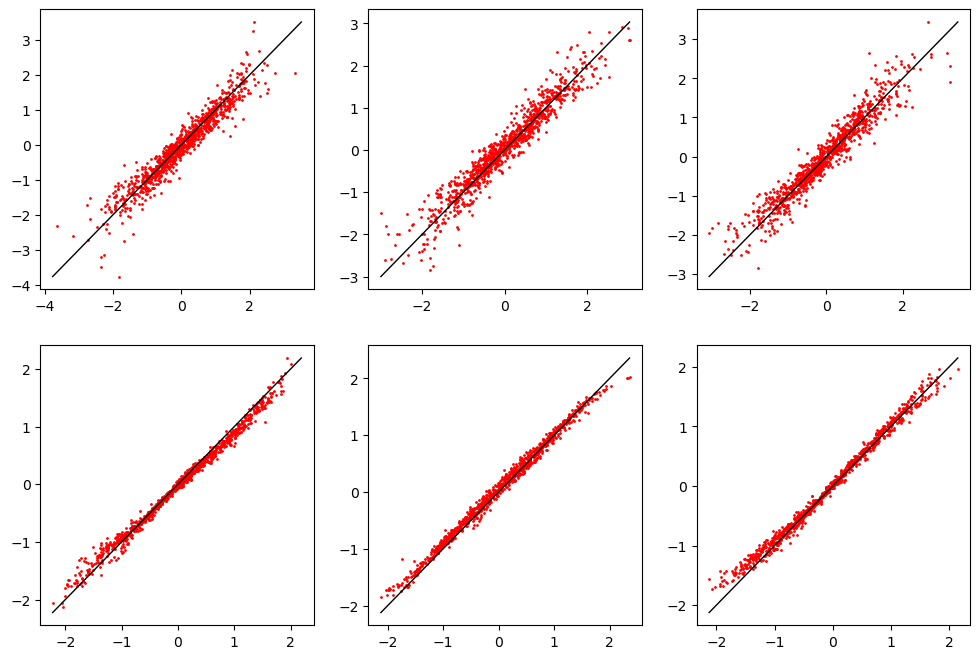

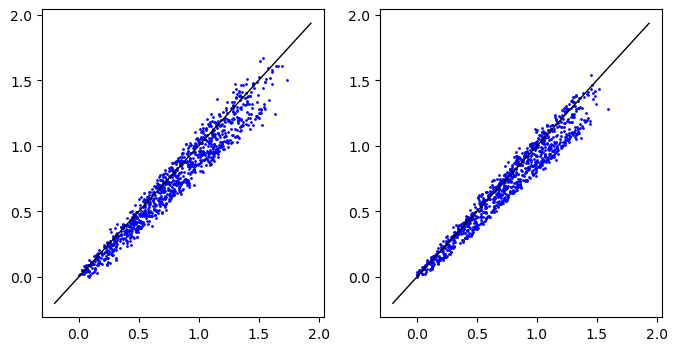

In [7]:
d, n= 3, 1000
x=np.random.standard_normal((d,n))
y=np.random.standard_normal((d,n))
p_x, p_y= np.ones((n,))/n, np.ones((n,))/n
qq_and_potential_plots(x,y,p_x,p_y,la=1e-2)

## Example 2

### QQ and potential plots for two Gaussian samples (in three dimensions) with different mean

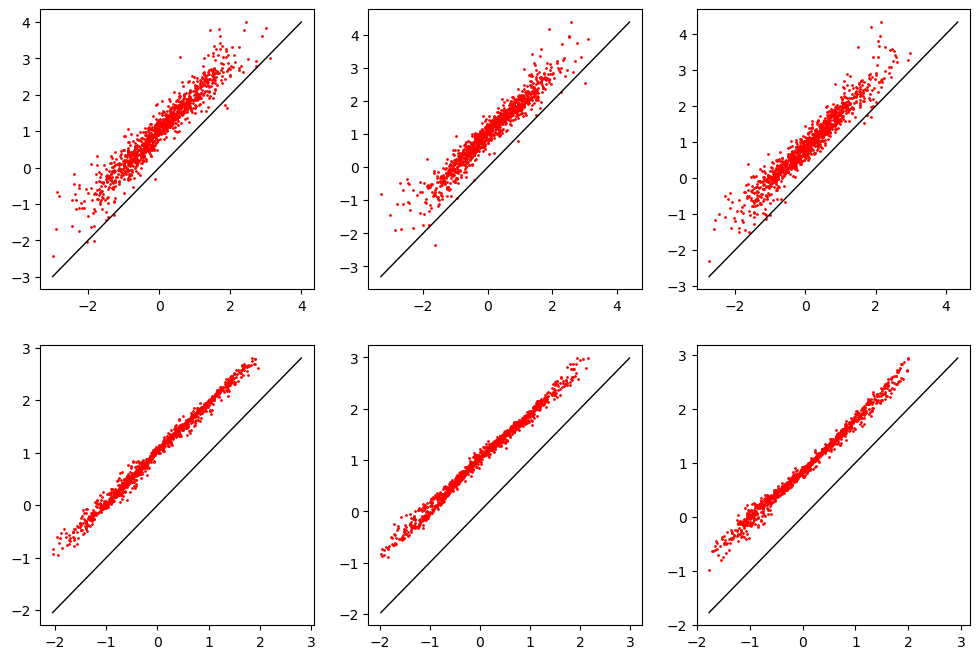

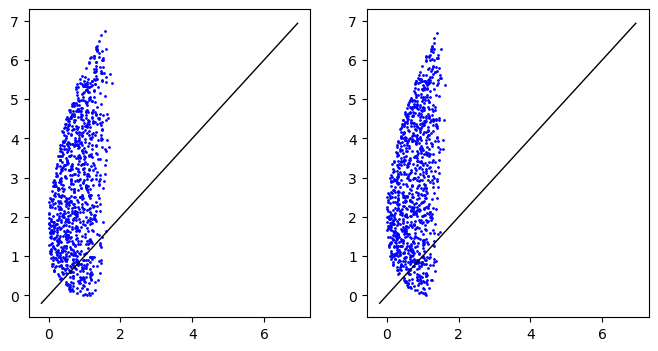

In [10]:
d, n= 3, 1000
x=np.random.standard_normal((d,n))
y=np.random.standard_normal((d,n))
y= (np.ones(d) + y.T).T # This will shift the mean of y at (1, 1, 1)
p_x, p_y= np.ones((n,))/n, np.ones((n,))/n
qq_and_potential_plots(x,y,p_x,p_y,la=1e-2)

## Example 3

### QQ and potential plots (standard Gaussian vs scaled Gaussian)

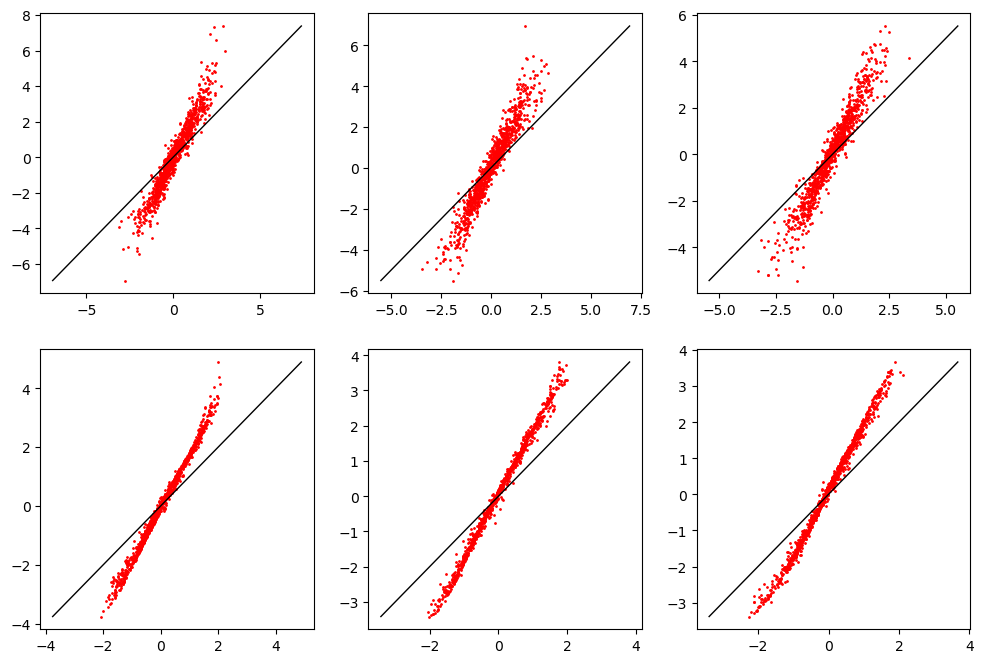

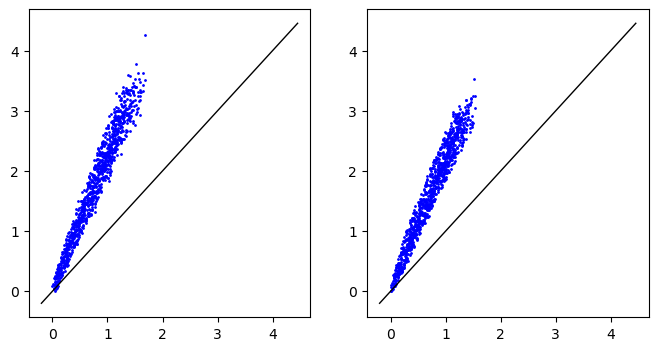

In [13]:
d, n= 3, 1000
x=np.random.standard_normal((d,n))
y=2*np.random.standard_normal((d,n))
p_x, p_y= np.ones((n,))/n, np.ones((n,))/n
qq_and_potential_plots(x,y,p_x,p_y,la=1e-2)

## Example 4

### QQ and potential plots (Gaussian vs Laplace)

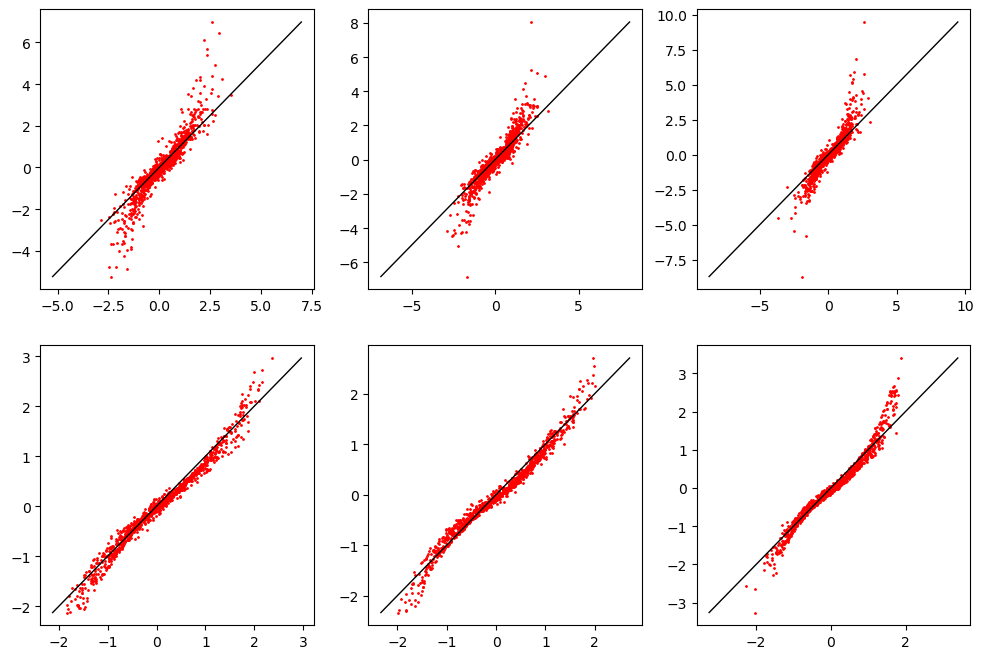

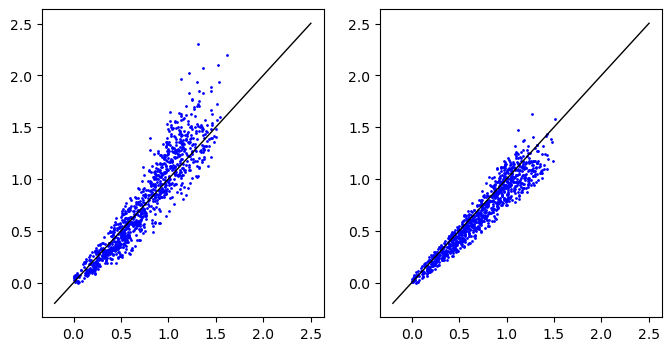

In [16]:
d, n= 3, 1000
x=np.random.standard_normal((d,n))
y=np.random.laplace(size=(d,n))
p_x, p_y= np.ones((n,))/n, np.ones((n,))/n
qq_and_potential_plots(x,y,p_x,p_y,la=1e-2)